In [1]:
import os

import matplotlib.pyplot as plt

from multitask.models.individual import get_individual_model
from multitask.models.parallel import get_parallel_model
from multitask.models.task_switching import get_task_model

In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ["#FBC5F4", "#FFB7BC", "#BDC0FF", "#777CD8"]

In [3]:
path_figure = os.path.join('svg', 'figureS23_parameters.svg')

In [4]:
def parameters_sequential(num_tasks, input_size, output_size, num_layers, num_hidden):
    num_params_input = num_hidden * (input_size + 1)
    num_params_hidden = num_hidden * (num_layers - 1) * (num_hidden + 1)
    num_params_output = output_size * (num_hidden + 1)
    return num_tasks * (num_params_input + num_params_hidden + num_params_output)

def parameters_parallel(num_tasks, input_size, output_size, num_layers, num_hidden):
    num_params_input = num_hidden * (input_size + 1)
    num_params_hidden = num_hidden * (num_layers - 1) * (num_hidden + 1)
    num_params_output = output_size * (num_hidden + 1)
    return num_params_input + num_params_hidden + num_tasks * num_params_output

def parameters_task_switching_different(num_tasks, input_size, output_size, num_layers, num_hidden):
    num_params_input = num_hidden * input_size  # HI
    num_params_hidden = (num_hidden ** 2) * (num_layers - 1)  # H^2(L - 1)
    num_params_output = output_size * num_hidden  # OH
    num_params_context = num_hidden * num_layers * num_tasks  # HLT
    return  num_params_context + num_params_input + num_params_hidden + num_params_output

def parameters_task_switching_same(num_tasks, input_size, output_size, num_layers, num_hidden):
    num_params_input = num_hidden * input_size  # HI
    num_params_hidden = (num_hidden ** 2) * (num_layers - 1)  # H^2(L - 1)
    num_params_output = output_size * num_hidden  # OH
    num_params_context = num_layers * num_tasks  # LT
    return  num_params_context + num_params_input + num_params_hidden + num_params_output

In [5]:
num_tasks = 10
num_layers = 10
num_hidden = 100
input_size = 784
output_size = 2

list_tasks = list(range(1, num_tasks + 1))

sequential = []
parallel = []
task_switching = []

for i_tasks in list_tasks:
    sequential.append(parameters_sequential(i_tasks, input_size, output_size, num_layers, num_hidden))
    parallel.append(parameters_parallel(i_tasks, input_size, output_size, num_layers, num_hidden))
    task_switching.append(parameters_task_switching_same(i_tasks, input_size, output_size, num_layers, num_hidden))


num_hidden = 1000
num_tasks = 100

parallel_deep = []
task_switching_deep_different = []
task_switching_deep_same = []

list_tasks_deep = [1, 20, 40, 60, 80, 100]

for i_tasks in list_tasks_deep:
    parallel_deep.append(parameters_parallel(i_tasks, input_size, output_size, num_layers, num_hidden))
    task_switching_deep_different.append(parameters_task_switching_different(i_tasks, input_size, output_size, num_layers, num_hidden))
    task_switching_deep_same.append(parameters_task_switching_same(i_tasks, input_size, output_size, num_layers, num_hidden))

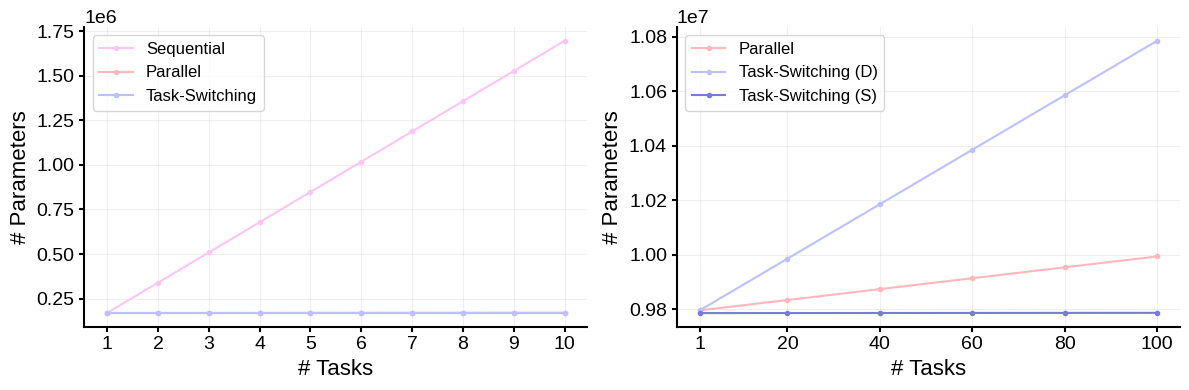

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(list_tasks, sequential, '.-', color=palette[0])
ax[0].plot(list_tasks, parallel, '.-', color=palette[1])
ax[0].plot(list_tasks, task_switching, '.-', color=palette[2])

ax[0].legend(['Sequential', 'Parallel', 'Task-Switching'])
ax[0].set_xlabel('# Tasks')
ax[0].set_ylabel('# Parameters')
ax[0].xaxis.set_ticks(list_tasks)
ax[0].grid(alpha=0.2)

# ax[1].plot(list_tasks, sequential, '.-')
next(ax[1]._get_lines.prop_cycler) 
ax[1].plot(list_tasks_deep, parallel_deep, '.-', color=palette[1])
ax[1].plot(list_tasks_deep, task_switching_deep_different, '.-', color=palette[2])
ax[1].plot(list_tasks_deep, task_switching_deep_same, '.-', color=palette[3])

ax[1].legend(['Parallel', 'Task-Switching (D)', 'Task-Switching (S)'])
ax[1].set_xlabel('# Tasks')
ax[1].set_ylabel('# Parameters')
ax[1].xaxis.set_ticks(list_tasks_deep)
ax[1].grid(alpha=0.2)

fig.tight_layout()
fig.savefig(path_figure)
plt.show()

In [7]:
def get_parameters_model(model):
    return sum(p.numel() for p in model.parameters())


def get_task_placeholder(num_tasks):
    tasks = {}

    for i_task in range(num_tasks):
        task_name = f'Task_{i_task}'
        tasks[task_name] = {}
        tasks[task_name]['data'] = None
        tasks[task_name]['activations'] = num_tasks * [0]
        tasks[task_name]['activations'][i_task] = 1

    return tasks

In [8]:
num_hidden = 100
num_layers = 10

layers_hidden = [num_hidden] * num_layers
idxs_contexts = list(range(num_layers))

for num_tasks in list_tasks_deep:
    tasks = get_task_placeholder(num_tasks)

    model_task_switching = get_task_model(tasks, layers_hidden, idxs_contexts, 'cpu')
    params_task_switching = get_parameters_model(model_task_switching)

    model_sequential = get_individual_model(layers_hidden, 'cpu')
    params_sequential = num_tasks * get_parameters_model(model_sequential)

    model_parallel = get_parallel_model(num_tasks, layers_hidden, 'cpu')
    params_parallel = get_parameters_model(model_parallel)

    predicted_params_sequential = parameters_sequential(num_tasks, 784, 2, num_layers, num_hidden)
    predicted_params_parallel = parameters_parallel(num_tasks, 784, 2, num_layers, num_hidden)
    predicted_params_task_switching = parameters_task_switching_different(num_tasks, 784, 2, num_layers, num_hidden)

    assert params_sequential == predicted_params_sequential
    assert params_parallel == predicted_params_parallel
    assert params_task_switching == predicted_params_task_switching
